In [2]:
def get_times(target,source=db["testcases"+testname]):
    """convert the time stamps from int to datetame """
    x= list(db["testcases"+testname].find({'name':target}))[0]
    x['execution']=datetime.utcfromtimestamp(int(x['execution']))
    x['begin']=datetime.utcfromtimestamp(int(x['begin']))
    x['end']=datetime.utcfromtimestamp(int(x['end']))
    x['warmup']=datetime.utcfromtimestamp(int(x['warmup']))
    return x 

def calculate_power(times,source=sensors):
    """need a time object from get_times function and return 2 dataframes  """
    cursor =sensors.find({'target':'system','timestamp' :{'$gte':times['begin'],'$lte':times['end']}},{"_id":0,"timestamp":"timestamp","rapl.0.38.RAPL_ENERGY_PKG":"rapls"})
    results=pd.DataFrame(list(cursor),columns=['timestamp',"rapl"])
    results["rapl"]=results["rapl"].apply(lambda row :math.ldexp( row['0']['38']['RAPL_ENERGY_PKG'],-32))
    warmup=results[(results["timestamp"]<=times["execution"]) & (results["timestamp"]>times["warmup"] )]
    execution = results[(results["timestamp"]>times["execution"]) ]
    return warmup , execution

def calculate_energy(times,source=sensors) : 
    """need a times object from get_times """
    warmup,execution =calculate_power(times)
    return   warmup["rapl"].sum() , execution["rapl"].sum()

def get_recap(target):
    """require a row from the database and not a times object"""
    times=get_times(target['name'])
    energy=calculate_energy(times)
    return {'name': target['name'] 
            ,'warmup time': (int(target['execution'])-int(target['warmup'])) 
            ,'warmup energy': energy[0] 
            ,'execution time': (int(target['end'])-int(target['execution']) )
            ,'execution energy': energy[1]
           }

def correction(self): 
    low = 0.25
    high = 0.75
    q1,q3 = self.quantile([low, high])
    mean =self.mean()
    std = self.std()   
    iqr=q3-q1
    inf,sup = q1-1.5*iqr,q3+1.5*iqr
#     inf,sup = mean-2*std ,mean+2*std
    return self[(self >inf )  & (self  < sup) ].dropna()

def correction2(self,measure="execution energy"): 
    
    low = 0.25
    high = 0.75
    q1,q3 = self[measure].quantile([low, high])
    iqr=q3-q1
    inf,sup = q1-1.5*iqr,q3+1.5*iqr
#     inf,sup = q1,q3
#     print(q1,q3)
    return self[(self[measure] >=inf )  & (self[measure]  <= sup) ].dropna()

def correct(self):
    s=self.groupby(["implementation"])
    s=s.apply(lambda x: x.correct2())
    return s.reset_index(drop=True)

def standarisation(self): 
    mean = self.mean()
    std= self.std()
    return self.apply(lambda row: (row-mean)/std)

def bootstrap(self):
    s=self.groupby(["implementation"])
    s=s.apply(lambda x: x.bootstrap2())
    return pd.DataFrame(index=list(s.index),data=list(s),columns=['min','max','shapirotest'])
    return s


def bootstraping2(self,measure="execution energy"): 
    
    bootstrap_dist = sns.algorithms.bootstrap(self[measure], n_boot=999, func=np.mean)
    inf=np.percentile(bootstrap_dist, 2.5)
    sup=np.percentile(bootstrap_dist, 97.5)
    shapiro=stats.shapiro(bootstrap_dist)
    return inf,sup,shapiro[1]
    
def bootstraping(self):
    bootstrap_dist = sns.algorithms.bootstrap(self, n_boot=999, func=np.mean)
    inf=np.percentile(bootstrap_dist, 2.5)
    sup=np.percentile(bootstrap_dist, 97.5)
    shapiro=stats.shapiro(bootstrap_dist)
    return inf,sup,shapiro[1]
    

def save_recap(self,suffix='',database=db,testname=testname):
    import json 
    records = json.loads(self.T.to_json()).values()
# records
    database["recap"+bench+suffix].insert_many(records)
    
def load_recap(suffix='',database=db,testname=testname):  
    return pd.DataFrame.from_dict(list(db["recap"+bench+suffix].find({})))

def get_palette(self): 
    l=self['implementation'].drop_duplicates()
    palette={'numba3': (0.86, 0.3712, 0.33999999999999997),
 'numba2': (0.86, 0.6832, 0.33999999999999997),
 'pypy3': (0.7247999999999999, 0.86, 0.33999999999999997),
 'pypy2': (0.41279999999999994, 0.86, 0.33999999999999997),
 'nuitka': (0.33999999999999997, 0.86, 0.5792000000000002),
 'pyston': (0.33999999999999997, 0.8287999999999999, 0.86),
 'cython': (0.33999999999999997, 0.5167999999999995, 0.86),
 'cpython2': (0.4752000000000003, 0.33999999999999997, 0.86),
 'cpython3': (0.7871999999999999, 0.33999999999999997, 0.86),
 'activepython': (0.86, 0.33999999999999997, 0.6207999999999999)}
    return [palette[i] for i in l ]


pd.DataFrame.get_palette=get_palette

pd.Series.correct=correction 
pd.DataFrame.correct2=correction2 
pd.DataFrame.correct=correct 

pd.DataFrame.bootstrap2=bootstraping2
pd.DataFrame.bootstrap=bootstrap
pd.Series.bootstrap=bootstraping 

pd.DataFrame.save_recap=save_recap
pd.Series.normalise=standarisation



In [1]:
import pymongo
import math 
import re
import pandas as pd
import numpy as np
import pylab 
from matplotlib import pyplot as plt
from scipy import stats 
from  qgrid import show_grid as show 
from datetime import datetime
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
today=!(date +"%d%m%y")
today=today[0]
testname="test4041218"
client = pymongo.MongoClient('172.16.45.8', 27017)
db = client.rapls
sensors= db["sensor"+testname]
sensors.create_index([('timestamp',pymongo.ASCENDING)])
measure='execution energy'
bench='trig'

In [5]:
show(times)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [7]:
regx = re.compile(".*", re.IGNORECASE)
times=pd.DataFrame.from_dict(list(db["testcases"+testname].find({"name":regx})))
times

,_id,begin,end,execution,name,warmup
0,5c0701834773825204a4901e,1543962947,1543963011,1543962966,tommtiv1cpython2trig50n0,1543962962
1,5c0701c547738253724f7d76,1543963011,1543963077,1543963022,tommtiv1cpython3trig50n0,1543963016
2,5c0701ff4773825529bb5ee1,1543963078,1543963135,1543963097,tommtiv1nuitkatrig50n0,1543963090
3,5c070252477382570945583a,1543963136,1543963218,1543963164,tommtiv1numba3trig50n0,1543963159
4,5c07026e47738258ccdcc9cf,1543963219,1543963246,1543963232,tommtiv1pypy3trig50n0,1543963231
5,5c0702db4773825a113f6903,1543963247,1543963355,1543963264,tommtiv1activepythontrig50n0,1543963255
6,5c0703054773825b31f36cbd,1543963355,1543963397,1543963363,tommtiv1cythontrig50n0,1543963359
7,5c07034f4773825c96e1e722,1543963398,1543963470,1543963416,tommtiv1numba2trig50n0,1543963410
8,5c0703634773825dbde113c2,1543963471,1543963491,1543963477,tommtiv1pypy2trig50n0,1543963476
9,5c0703a7477382600e2731cf,1543963492,1543963559,1543963512,tommtiv1pystontrig50n0,1543963507


In [88]:
regx = re.compile(bench+".*", re.IGNORECASE)
times=pd.DataFrame.from_dict(list(db["testcases"+testname].find({"name":regx})))
data=[]
times.apply(lambda row: data.append(get_recap(row)), axis=1)
data=pd.DataFrame.from_dict(data)
data["implementation"]= data["name"].apply(lambda name:re.search('tommtiv1(?P<name>.*)'+bench+'.*n', name).group(1))
data["loop"]=data["name"].apply(lambda name:re.search('tommtiv1.*'+bench+'(?P<a>.*)n', name).group(1))
# show(data)
# data.head()

In [79]:
# data= load_recap()
# data.save_recap('2')

Text(0.5,1,'trig')

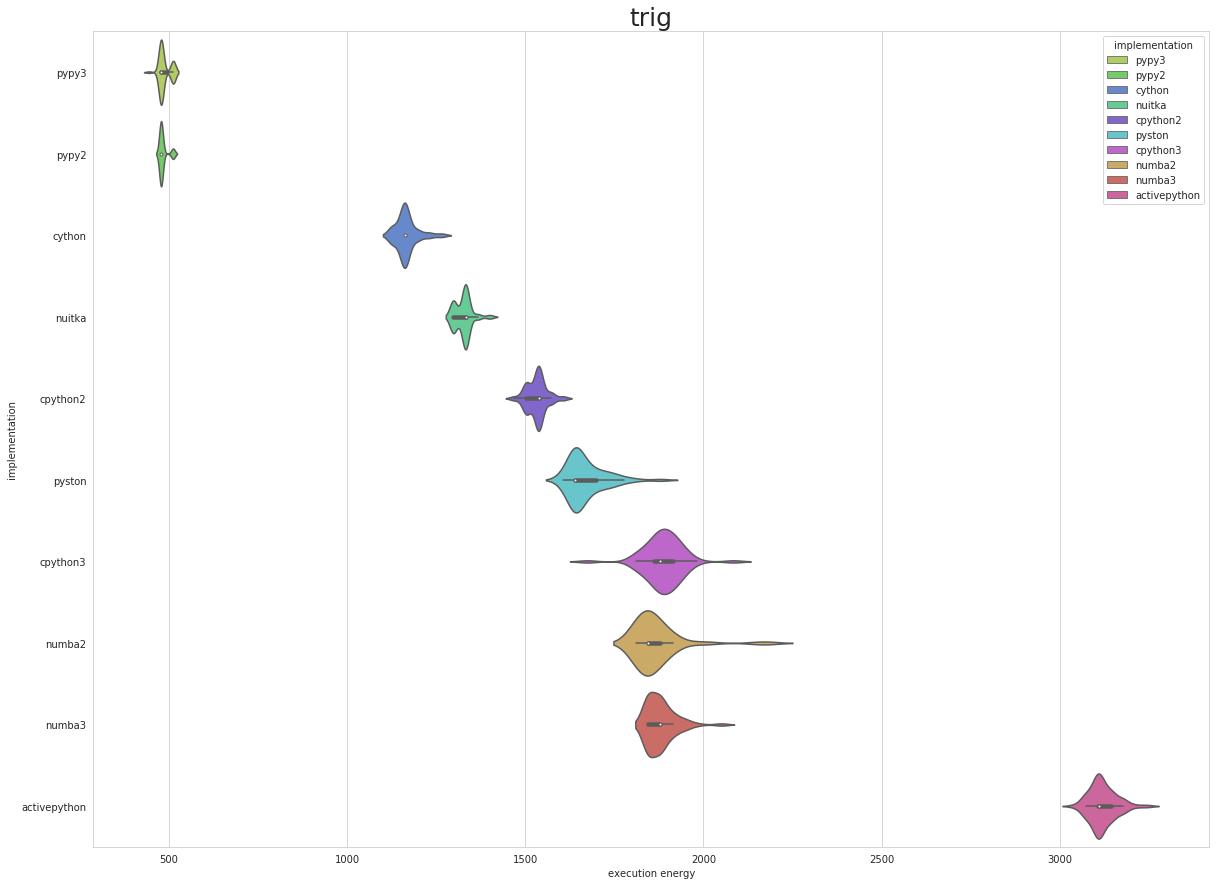

In [110]:
mystats20=data[data['loop']=='50']
# mystats20['log '+measure]=mystats20[measure]
# mystats20=mystats20.groupby(["implementation"])
# mystats20.loc[:,[measure,'implementation']]
# mystats20=mystats20.correct()
mystats20=mystats20.sort_values("execution energy",ascending=True)
plt.subplots(nrows=1,ncols=1,figsize=(20, 15))
sns.set_palette(mystats20.get_palette())
ax= sns.violinplot(y='implementation',x=measure,data=mystats20,hue='implementation',dodge=False,orient='h',scale="count")
ax.set_title(bench,size=25)
# ax.get_hue()

# mystats20.describe()
# ax.set(xscale="log")|
# mystats20[measure].quantile(0.1)
# mystats20.describe()

In [113]:
shapiro=mystats20.groupby('implementation')[measure].apply(lambda x:stats.shapiro(x)[1])
x=mystats20.groupby('implementation')[measure].agg(['count','min','max'])
x['shapirotest']=shapiro
x.index.name = None
ref='cpython2'
x['relative min']=x['min']/x.loc[ref,'max']
x['relative max']=x['max']/x.loc[ref,'min']
x=x.sort_values('relative max')
show(np.round(x, decimals=2))


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [108]:
x=mystats20.bootstrap()
x.index.name = None
ref='cpython2'
x['relative min']=x['min']/x.loc[ref,'max']
x['relative max']=x['max']/x.loc[ref,'min']
x=x.sort_values('relative max')
# show(np.round(x, decimals=2))
show(x)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

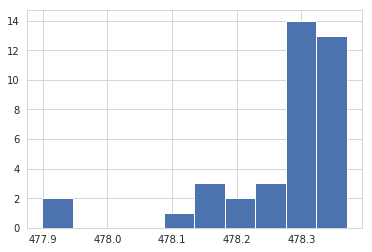

In [95]:
sns.set_palette('deep')
sample=mystats20.loc[mystats20['implementation']=='pypy2'][measure]
sample.hist()

min:477.9126251220703
max:478.3599884033203
shapiro test (0.7374345660209656, 6.965768193367694e-07)
38


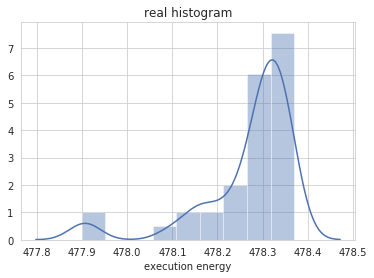

In [103]:
sample=mystats20.loc[mystats20['implementation']=='pypy2'][measure]
# print('percentile') 
# print (np.percentile(sample, 2.5))
# print (np.percentile(sample, 97.5))
sns.distplot(sample).set(title='real histogram')
print ('min:'+str(np.percentile(sample, 2.5)))
print ('max:'+str(np.percentile(sample, 97.5)))
print('shapiro test',str(stats.shapiro(sample)))
# stats.kstest(sample,'expon')
print(sample.count())

min:478.1651342773438
max:478.33567321777343
shapiro test (0.9454038143157959, 9.634568607123373e-19)


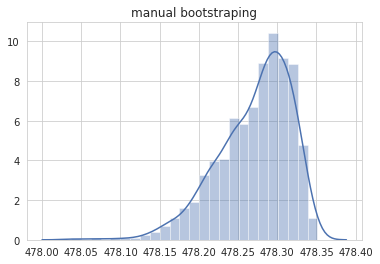

In [106]:
# sample=mystats20.loc[mystats20['implementation']=='cpython2'][measure]
bootstrap_dist = [np.mean(np.random.choice(sample, 5, replace=True)) for _ in range(999)]
sns.distplot(bootstrap_dist).set(title='manual bootstraping')
print ('min:'+str(np.percentile(bootstrap_dist, 2.5)))
print ('max:'+str(np.percentile(bootstrap_dist, 97.5)))
print('shapiro test',str(stats.shapiro(bootstrap_dist)))

min:1654.177506528582
max:1676.0809584481376
shapiro test (0.9969791173934937, 0.05546749755740166)


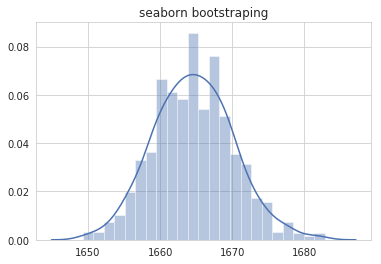

In [101]:
bootstrap_dist = sns.algorithms.bootstrap(sample, n_boot=999, func=np.mean)
sns.distplot(bootstrap_dist).set(title='seaborn bootstraping')
print ('min:'+str(np.percentile(bootstrap_dist, 2.5)))
print ('max:'+str(np.percentile(bootstrap_dist, 97.5)))
print('shapiro test',str(stats.shapiro(bootstrap_dist)))


In [100]:
x=mystats20.groupby('implementation').apply(lambda x: x[measure].normalise())
y=pd.DataFrame(data=x,index=x.index)
y.index.name=None
z=y.bootstrap()
s=y.groupby('implementation').apply(lambda x:stats.shapiro(x)[1]) 
y=y.groupby('implementation').agg(['min','max'])
y['shapiro'] = s
y.index.name=None
ref='cpython2'
x['relative min']=x['min']/x.loc[ref,'max']
x['relative max']=x['max']/x.loc[ref,'min']
x=x.sort_values('relative max')
show(np.round(x, decimals=2))


KeyError: 'min'

In [75]:
regx = re.compile("double.*", re.IGNORECASE)
data=pd.DataFrame.from_dict(list(db["recap"+testname].find({"name":regx})))
# show(data)

In [224]:

# len(mystats.unstack(level=0).index

In [170]:
# data["implementation"]= data["name"].apply(lambda name:re.search('tommtiv1(?P<name>.*)int40n', name).group(1))
mystats=data.groupby(["implementation","loop"])
# mystats=mystats.apply(lambda x : x.correct())
# mystats=mystats.groupby(level=0).mean()
# mystats=mystats.sort_values("execution energy",ascending=False)
mystats=mystats.mean()
show(mystats)

KeyError: 'implementation'

<IPython.core.display.Javascript object>


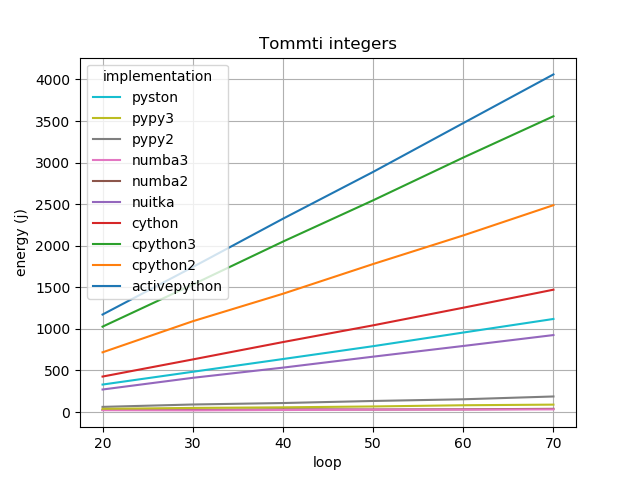

Text(0,0.5,'energy (j)')

In [217]:
xticks=[int(i) for i in mystats.unstack(level=0).index]
xticks=range(len(mystats.unstack(level=0).index))
x=mystats.unstack()
ax=x["execution energy"].T.plot(xticks=xticks,grid=True,title='Tommti integers',legend='reverse')
ax.set_ylabel('energy (j)')


Text(0.5,0,'energy(j)')

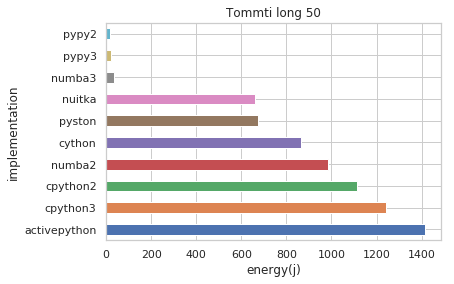

In [225]:
mystats20=data[data['loop']=='50']
mystats20=mystats20.correct()
mystats20=mystats20.groupby(["implementation"]).mean()
mystats20=mystats20.sort_values("execution energy",ascending=False)
mystats20['execution energy'].plot(kind='barh',grid=True,sort_columns=True,title="Tommti long 50").set_xlabel("energy(j)")

In [237]:
mystats20=data[data['loop']=='50']
mystats20.correct().groupby('implementation').describe()

execution energy                                       \
                          count         mean        std          min   
implementation                                                         
activepython               72.0  1414.807517  15.679932  1385.898254   
cpython2                   72.0  1113.941717  10.500085  1104.383118   
cpython3                   72.0  1243.057075  18.348360  1213.898804   
cython                     72.0   864.959869  17.170831   844.610718   
nuitka                     72.0   662.587525  11.915766   630.895020   
numba2                     72.0   984.151115  17.388857   961.546875   
numba3                     72.0    35.657617   4.500900    32.151245   
pypy2                      45.0    29.371335   2.541498    23.657410   
pypy3                      58.0    30.285446   2.501790    23.035706   
pyston                     72.0   673.635750  14.574836   662.439941   

                                                                    \
                        25%          50%          75%          max   
implementation                                                       
activepython    1399.879623  1419.686859  1428.061508  1436.903687   
cpython2        1108.929749  1111.298401  1113.002029  1147.268860   
cpython3        1221.678513  1246.434235  1255.936996  1285.780090   
cython           848.359009   852.826996   882.376755   888.403442   
nuitka           665.605515   667.211945   667.984146   668.789185   
numba2           964.894714   994.274536  1000.276031  1002.403748   
numba3            34.114716    35.473877    35.925369    63.398010   
pypy2             28.139832    30.077515    31.231995    33.430237   
pypy3             29.251816    30.935364    32.199097    33.110657   
pyston           665.551804   666.650543   668.111252   703.857483   

               execution time            ...  warmup energy              \
                        count       mean ...            75%         max   
implementation                           ...                              
activepython             72.0  38.638889 ...     140.556854  144.527222   
cpython2                 72.0  30.111111 ...     106.371429  110.299805   
cpython3                 72.0  33.750000 ...     109.019211  144.142395   
cython                   72.0  23.486111 ...      72.220291  106.028320   
nuitka                   72.0  17.875000 ...      67.582443   71.789307   
numba2                   72.0  26.569444 ...     108.610062  143.367676   
numba3                   72.0   1.027778 ...      31.741470   34.479614   
pypy2                    45.0   1.000000 ...       0.000000    0.000000   
pypy3                    58.0   1.000000 ...       0.000000    0.000000   
pyston                   72.0  18.222222 ...      69.673279   72.866394   

               warmup time                                               
                     count      mean       std  min  25%  50%  75%  max  
implementation                                                           
activepython          72.0  3.791667  0.408966  3.0  4.0  4.0  4.0  4.0  
cpython2              72.0  2.972222  0.165489  2.0  3.0  3.0  3.0  3.0  
cpython3              72.0  3.194444  0.398550  3.0  3.0  3.0  3.0  4.0  
cython                72.0  2.236111  0.427672  2.0  2.0  2.0  2.0  3.0  
nuitka                72.0  1.736111  0.443833  1.0  1.0  2.0  2.0  2.0  
numba2                72.0  3.111111  0.316475  3.0  3.0  3.0  3.0  4.0  
numba3                72.0  0.625000  0.487520  0.0  0.0  1.0  1.0  1.0  
pypy2                 45.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
pypy3                 58.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
pyston                72.0  1.986111  0.117851  1.0  2.0  2.0  2.0  2.0  

[10 rows x 32 columns]

In [217]:
mystats20=data[data['loop']=='50']
mystats20=mystats20.groupby(["implementation"])
s=mystats20.apply(lambda x: x.correct())
# mystats20.describe()
s.reset_index(drop=True)
s.groupby(["implementation"]).describe()
# mystats20.describe()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'implementation' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


execution energy                                       \
                          count         mean        std          min   
implementation                                                         
activepython               72.0  1414.807517  15.679932  1385.898254   
cpython2                   73.0  1113.810224  10.487264  1104.342712   
cpython3                   73.0  1242.654904  18.541671  1213.698608   
cython                     72.0   864.959869  17.170831   844.610718   
nuitka                     72.0   662.587525  11.915766   630.895020   
numba2                     72.0   984.151115  17.388857   961.546875   
numba3                     73.0    35.592781   4.503734    30.924561   
pypy2                      81.0    16.317408  14.806127     0.000000   
pypy3                      82.0    21.421413  14.022438     0.000000   
pyston                     72.0   673.635750  14.574836   662.439941   

                                                                    \
                        25%          50%          75%          max   
implementation                                                       
activepython    1399.879623  1419.686859  1428.061508  1436.903687   
cpython2        1108.857971  1111.279053  1112.967712  1147.268860   
cpython3        1220.955383  1246.217163  1255.851196  1285.780090   
cython           848.359009   852.826996   882.376755   888.403442   
nuitka           665.605515   667.211945   667.984146   668.789185   
numba2           964.894714   994.274536  1000.276031  1002.403748   
numba3            33.951660    35.464966    35.924377    63.398010   
pypy2              0.000000    25.302612    30.253845    33.430237   
pypy3              0.000000    29.370117    31.773041    33.110657   
pyston           665.551804   666.650543   668.111252   703.857483   

               execution time            ...  warmup energy              \
                        count       mean ...            75%         max   
implementation                           ...                              
activepython             72.0  38.638889 ...     140.556854  144.527222   
cpython2                 73.0  30.109589 ...     106.439636  110.299805   
cpython3                 73.0  33.739726 ...     109.196411  144.142395   
cython                   72.0  23.486111 ...      72.220291  106.028320   
nuitka                   72.0  17.875000 ...      67.582443   71.789307   
numba2                   72.0  26.569444 ...     108.610062  143.367676   
numba3                   73.0   1.027397 ...      31.662109   34.479614   
pypy2                    81.0   0.555556 ...       0.000000    0.000000   
pypy3                    82.0   0.707317 ...       0.000000   32.741455   
pyston                   72.0  18.222222 ...      69.673279   72.866394   

               warmup time                                               
                     count      mean       std  min  25%  50%  75%  max  
implementation                                                           
activepython          72.0  3.791667  0.408966  3.0  4.0  4.0  4.0  4.0  
cpython2              73.0  2.972603  0.164368  2.0  3.0  3.0  3.0  3.0  
cpython3              73.0  3.205479  0.406848  3.0  3.0  3.0  3.0  4.0  
cython                72.0  2.236111  0.427672  2.0  2.0  2.0  2.0  3.0  
nuitka                72.0  1.736111  0.443833  1.0  1.0  2.0  2.0  2.0  
numba2                72.0  3.111111  0.316475  3.0  3.0  3.0  3.0  4.0  
numba3                73.0  0.616438  0.489618  0.0  0.0  1.0  1.0  1.0  
pypy2                 81.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
pypy3                 82.0  0.024390  0.155207  0.0  0.0  0.0  0.0  1.0  
pyston                72.0  1.986111  0.117851  1.0  2.0  2.0  2.0  2.0  

[10 rows x 32 columns]

In [49]:
mystats20=data[data['loop']=='50']
mystats20=mystats20.groupby(["implementation"])
names =[]
shapirotests={}
kstest={}
show(mystats20)
# y= pd.Series(stats.norm.rvs(0,1,30))
# fig, axes = plt.subplots(nrows=3,ncols=4,figsize=(20, 15))
j=0

sns.set(style="whitegrid")
for i in mystats20: 
    names.append(i[0])
    mes=i[1][measure]
# #     print(mes)
#     break
    sns.violinplot(mes,showmeans=True,orient ='h',scale="count")
    break
    
#     shapirotests[i[0]]=stats.shapiro(mes)
#     kstest[i[0]]=stats.ks_2samp(mes,y)
#     axes[int(j/4),j%4].violinplot(mes,showmeans=True)
#     axes[int(j/4),j%4].set_title(i[0])
    j+=1

TypeError: data_frame must be DataFrame or Series, not <class 'pandas.core.groupby.groupby.DataFrameGroupBy'>

{}

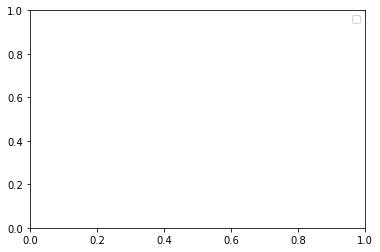

In [10]:
mystats20=data[data['loop']=='20']
mystats20=mystats20.groupby(["implementation"])
names =[]
shapirotests={}
kstest={}
y= pd.Series(stats.norm.rvs(0,1,30))
for i in mystats20: 
    names.append(i[0])
    mes=i[1][measure].normalise()
    shapirotests[i[0]]=stats.shapiro(mes)
    kstest[i[0]]=stats.ks_2samp(mes,y)
    plt=mes.plot.kde(grid=True)

plt.legend(names)
# plt.grid(True)
shapirotests

In [99]:
mystats20=data[data['loop']=='20']
mystats20=mystats20.groupby(["implementation"])
# mystats20.loc['activepython'][measure].hist()

AttributeError: Cannot access callable attribute 'loc' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [12]:
# data["implementation"]= data["name"].apply(lambda name:re.search('tommtiv1(?P<name>.*)int40n', name).group(1))
mystats=data.groupby(["implementation","loop"])
# mystats=mystats.apply(lambda x : x.correct())
# mystats=mystats.groupby(level=0).mean()
# mystats=mystats.sort_values("execution energy",ascending=False)
mystats=mystats.mean()
show(mystats)

KeyError: 'implementation'

In [9]:
measure='execution energy'
data1=data[data["name"].str.match(".*cpython2int50n.*")>0 ]
# data1=data1.loc[data1[measure]<1500]
stats.shapiro(data1[measure])
# data1[measure].plot.kde()
# stats.norm.fit(data1[measure])
# stats.kstest(data1[measure],'t')

# print(data1[measure].count())
# dist_names = [ 'alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic', 'genpareto', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'wald', 'weibull_min', 'weibull_max', 'wrapcauchy']
# l={ i :+stats.kstest(data1[measure],i) for i in dist_names}

pylab.violinplot(data1[measure])

ValueError: Data must be at least length 3.

In [26]:
y= pd.Series(stats.norm.rvs(0,1,30))
stats.shapiro(y)

(0.9712673425674438, 0.5744072794914246)

In [18]:
x=x.normalise()
x.plot.kde()
stats.norm.fit(x)
y= pd.Series(stats.norm.rvs(0,1,30))
y.plot.kde(color='red').legend(['int20','normal'])


NameError: name 'x' is not defined

shapiro x: (0.745396614074707, 7.679681402805727e-06)
kstest x: KstestResult(statistic=0.3339205959026663, pvalue=0.0017463423602741557)
shapiro y: (0.9626308083534241, 0.36098945140838623)
kstest y: KstestResult(statistic=0.23112484187471954, pvalue=0.06837342119986123)
ks 2 x,y: Ks_2sampResult(statistic=0.23333333333333334, pvalue=0.34203417981555007)


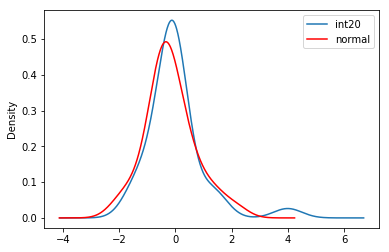

In [388]:
# y1=y

print('shapiro x: ' +str(stats.shapiro(x)))
print('kstest x: '  + str(stats.kstest(x,'norm')))
print('shapiro y: ' +str(stats.shapiro(y1)))
print('kstest y: ' +str(stats.kstest(y1,'norm')))
print('ks 2 x,y: ' +str(stats.ks_2samp(x,y1)))
x.plot.kde()
y1.plot.kde(color='red').legend(['int20','normal'])



In [397]:

data1.to_csv("int40.csv")

30


(0.5592572689056396, 2.4057747793904127e-08)

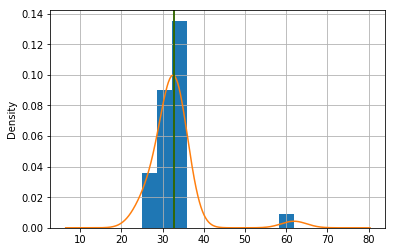

In [117]:
regx = re.compile(".*numba2int40n.*", re.IGNORECASE)
times1=pd.DataFrame.from_dict(list(db["testcases"+testname].find({"name":regx})))
# data1 = pd.DataFrame(columns=['name','warmup time','warmup energy','execution time ','execution energy']) 
data1=[]
times1.apply(lambda row: data1.append(get_recap(row)), axis=1)
    
data1=pd.DataFrame.from_dict(data1)
measure='execution energy'
y= data1[measure]
# std=data1[measure].std()
# data1=data1.append(data1)
# data1=data1.append(data1)

plt=y.hist(density=True)
y.plot.kde(grid=True)
plt.axvline(x=y.mean(),color="red")
plt.axvline(x=y.median(),color="green")
print(data1[measure].count())
stats.shapiro(data1[measure])

# show(data1)

30


(0.7291773557662964, 4.270251793059288e-06)

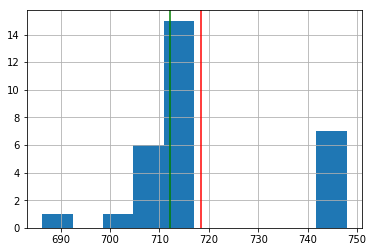

In [101]:
measure='execution energy'
y= data1[measure]
# std=data1[measure].std()
# data1=data1.append(data1)
# data1=data1.append(data1)

plt=y.hist()
plt.axvline(x=y.mean(),color="red")
plt.axvline(x=y.median(),color="green")
print(data1[measure].count())
stats.shapiro(data1[measure])

# print("moyenne: ",y.correct().mean(),"\nmediane :",y.correct().median())

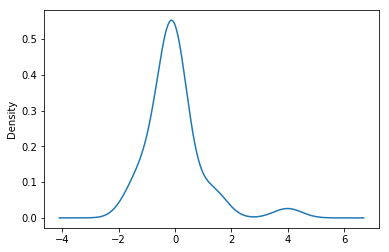

In [171]:
z=data1[measure].correct()

mean = z.mean()
std= z.std()
z["standar"+measure]=z.apply(lambda x:(x-mean)/std)
# show(z)
zc= z["standar"+measure]
# zc

# zc=z.correct()
# pylab.violinplot(z.correct(),showmeans=True)
zc.mean()

-3.6271160595083647e-16